In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#DATA ( The Oxford Flowers 102 dataset )
#( https://www.kaggle.com/datasets/waseemalastal/the-oxford-flowers-102-dataset?utm_source=chatgpt.com )

In [7]:
%cd "/content/drive/MyDrive/Bootcamp/W4_DL/C1_M5"

/content/drive/MyDrive/Bootcamp/W4_DL/C1_M5


In [8]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [9]:
from torchvision import datasets
from torch.utils.data import Subset

TRAIN_DIR = "/content/drive/MyDrive/Bootcamp/W4_DL/C1_M5/TRAN"

base_train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
base_test_ds  = datasets.ImageFolder(TRAIN_DIR, transform=test_tf)

keep_classes = base_train_ds.classes[:51]
keep_set = set(keep_classes)

train_indices = [
    i for i, (_, y) in enumerate(base_train_ds.samples)
    if base_train_ds.classes[y] in keep_set
]

test_indices = [
    i for i, (_, y) in enumerate(base_test_ds.samples)
    if base_test_ds.classes[y] in keep_set
]

train_ds_51 = Subset(base_train_ds, train_indices)
test_ds_51  = Subset(base_test_ds, test_indices)

print("Keep classes:", len(keep_classes))
print("Train_51:", len(train_ds_51), "Test_51:", len(test_ds_51))

Keep classes: 51
Train_51: 2853 Test_51: 2853


In [10]:
import torch, random, numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds_51, batch_size=64, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds_51,  batch_size=64, shuffle=False, num_workers=2)

In [12]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 51)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
from tqdm import tqdm
import torch

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += images.size(0)

    return total_loss / total, total_correct / total


def evaluate(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total += images.size(0)

    return total_loss / total, total_correct / total


In [15]:
epochs = 3

for epoch in range(epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
    print(f"Test  Loss: {te_loss:.4f} | Test  Acc: {te_acc:.4f}")


100%|██████████| 45/45 [02:15<00:00,  3.02s/it]



Epoch 1/3
Train Loss: 2.4825 | Train Acc: 0.4511
Test  Loss: 0.9355 | Test  Acc: 0.8510


100%|██████████| 45/45 [00:22<00:00,  1.96it/s]



Epoch 2/3
Train Loss: 0.9329 | Train Acc: 0.8517
Test  Loss: 0.2944 | Test  Acc: 0.9657


100%|██████████| 45/45 [00:23<00:00,  1.89it/s]



Epoch 3/3
Train Loss: 0.5067 | Train Acc: 0.9134
Test  Loss: 0.1674 | Test  Acc: 0.9758


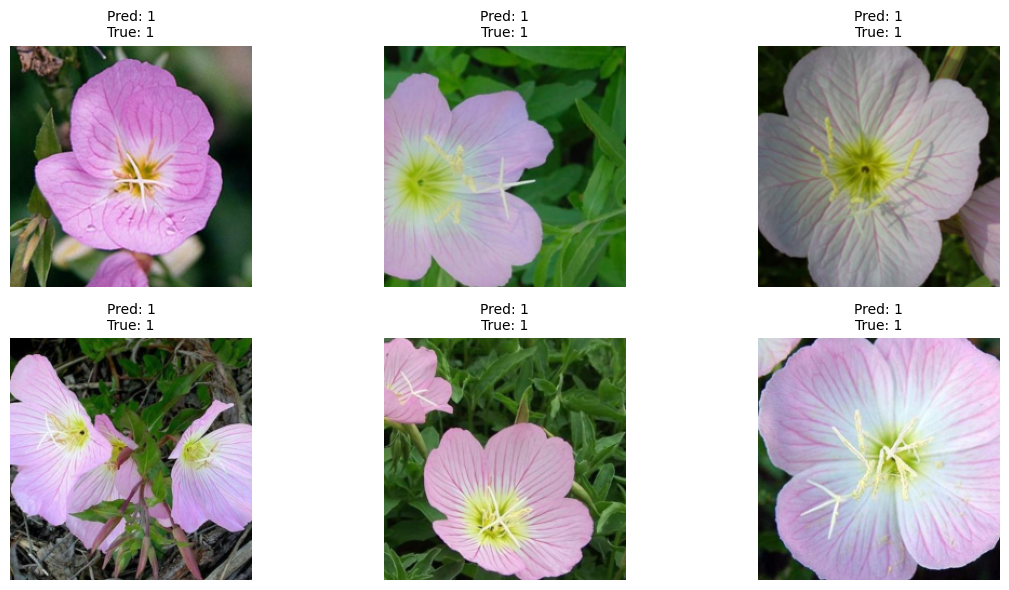

In [17]:
import matplotlib.pyplot as plt
import torch

model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.inference_mode():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

idx_to_class = {v: k for k, v in full_ds.class_to_idx.items()}

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    img = images[i].cpu().permute(1, 2, 0)
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = img.clamp(0, 1)

    pred_name = idx_to_class[preds[i].item()]
    true_name = idx_to_class[labels[i].item()]

    plt.imshow(img)
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#####################################################

In [19]:
import torch
import torch.nn as nn

class DeepCNN(nn.Module):
    def __init__(self, num_classes=51):
        super().__init__()

        self.features = nn.Sequential(
            ####
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            ####
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            ####
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            ######
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DeepCNN(num_classes=51).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
from tqdm import tqdm
import torch

def train_one_epoch(model, loader):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += images.size(0)

    return total_loss / total, total_correct / total


def evaluate(model, loader):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0

    with torch.inference_mode():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total += images.size(0)

    return total_loss / total, total_correct / total

In [22]:
epochs = 3

for epoch in range(epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
    print(f"Test  Loss: {te_loss:.4f} | Test  Acc: {te_acc:.4f}")

100%|██████████| 45/45 [00:25<00:00,  1.73it/s]



Epoch 1/3
Train Loss: 3.5191 | Train Acc: 0.1248
Test  Loss: 3.0814 | Test  Acc: 0.1672


100%|██████████| 45/45 [00:23<00:00,  1.90it/s]



Epoch 2/3
Train Loss: 3.0738 | Train Acc: 0.1658
Test  Loss: 2.6545 | Test  Acc: 0.2401


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]



Epoch 3/3
Train Loss: 2.8518 | Train Acc: 0.2079
Test  Loss: 2.5200 | Test  Acc: 0.2990


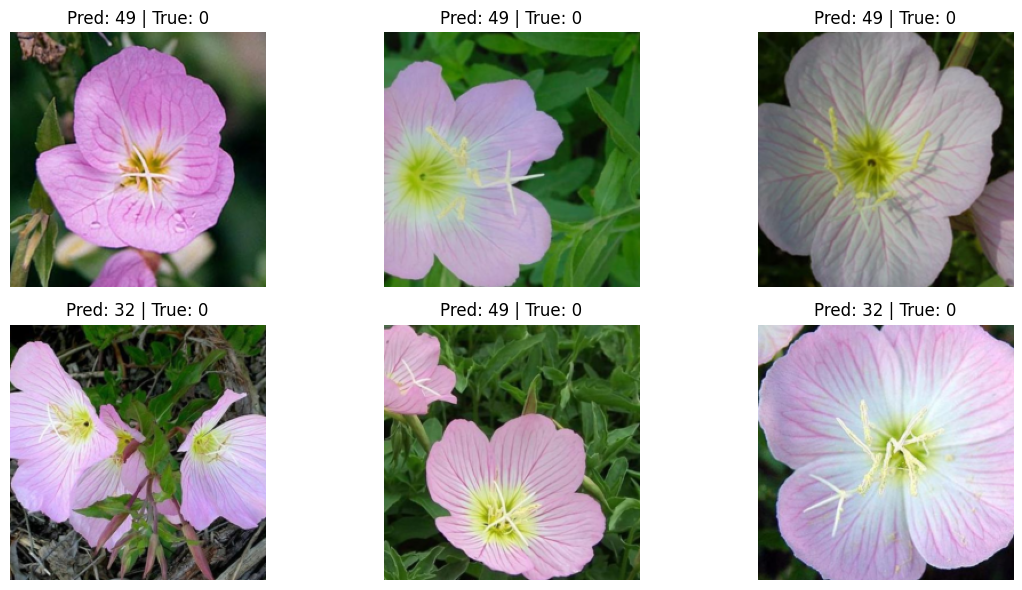

In [23]:
import matplotlib.pyplot as plt

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.inference_mode():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)

    img = images[i].cpu().permute(1,2,0)
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = img.clamp(0,1)

    plt.imshow(img)
    plt.title(f"Pred: {preds[i].item()} | True: {labels[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#####################################

In [26]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 51)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
epochs = 3
for epoch in range(epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
    print(f"Test  Loss: {te_loss:.4f} | Test  Acc: {te_acc:.4f}")


100%|██████████| 45/45 [00:25<00:00,  1.80it/s]



Epoch 1/3
Train Loss: 3.6455 | Train Acc: 0.1791
Test  Loss: 3.0763 | Test  Acc: 0.4055


100%|██████████| 45/45 [00:24<00:00,  1.86it/s]



Epoch 2/3
Train Loss: 2.7493 | Train Acc: 0.4125
Test  Loss: 1.8861 | Test  Acc: 0.6022


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]



Epoch 3/3
Train Loss: 1.8678 | Train Acc: 0.6179
Test  Loss: 1.1233 | Test  Acc: 0.8044


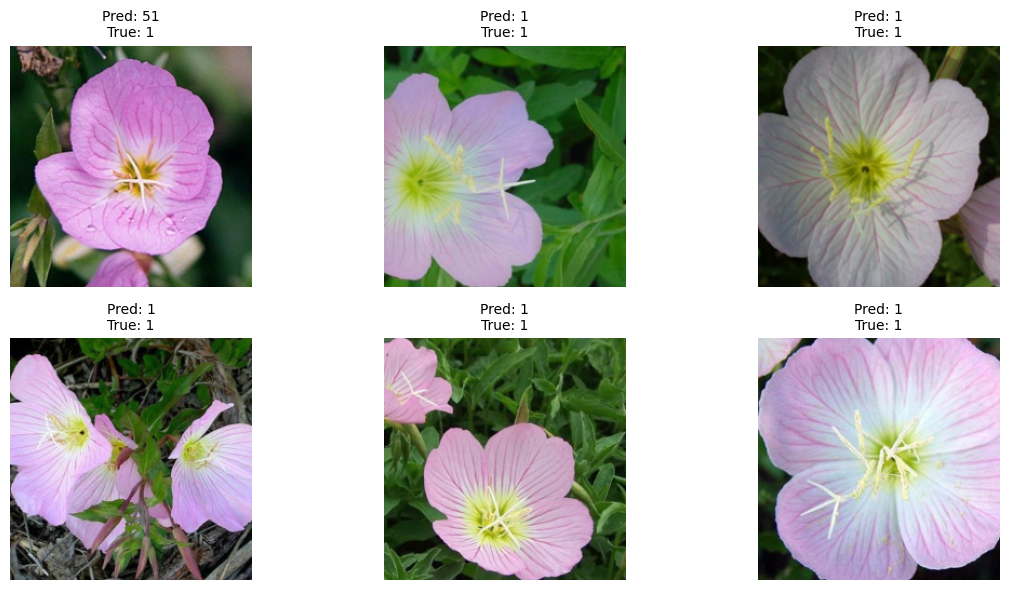

In [28]:
import matplotlib.pyplot as plt
import torch

model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.inference_mode():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# تحويل index -> class name
idx_to_class = {v: k for k, v in full_ds.class_to_idx.items()}

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = images[i].cpu().permute(1, 2, 0)
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = img.clamp(0, 1)

    pred_name = idx_to_class[preds[i].item()]
    true_name = idx_to_class[labels[i].item()]

    plt.imshow(img)
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()